In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp
import at
import math
from tqdm import tqdm

# Selfmade files
from functions import *
from PID import *

# Import ring information
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

In [2]:
# Lattice creation
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()

lat2 = at.Lattice(ring, energy=6.e9)
lat2.radiation_off() 

lat3 = at.Lattice(ring, energy=6.e9)
lat3.radiation_off()

# Obtaining Ids
cor_ids = at.get_refpts(lat, at.elements.Corrector)
bpm_ids = at.get_refpts(lat, at.elements.Monitor)
quad_ids = at.get_refpts(lat, at.elements.Quadrupole)

# BPMs positions
s_pos = lat.get_s_pos(bpm_ids)

Ring model:

$ y(t) = R_m \cdot \Delta q_i(t) + R_c \cdot \Delta \theta_i(t - \Delta t) $


In [3]:
dkick = 0.0001
offset = 0.0001
Rm, Rc = response_matrices(lat, dkick, offset, 1)

In [4]:
def tracking(x0, xp0, y0, yp0, dp, lat, nturns, refpts):
    pin1 = [np.array([x0]), np.array([xp0])]
    pin2 = [np.array([y0]), np.array([yp0])]
    pin3 = [np.array([dp])]
    new_pin = np.concatenate((pin1, pin2, pin3, [np.zeros(1)]))
    pout = at.track.lattice_pass(lat, new_pin.copy(), nturns, refpts)

    return pout

# at.shift_elem(lat[quad_ids[0]], deltax=0.0001, deltaz=0.0, relative=False)
# pout = tracking(0, 0, 0, 0, 0, lat, 1, refpts = bpm_ids)
# plt.plot(s_pos, pout[0, 0, :, -1], 'g.-')
# # n_sv = 80
# # Rcinv = svd_solve(Rc, n_sv)
# # change_correctors_kick_angle(lat,  np.dot(Rcinv.T, -pout[0, 0, :, -1]))
# # pout = tracking(0, 0, 0, 0, 0, lat, 1, refpts = bpm_ids)
# # plt.plot(s_pos, pout[0, 0, :, -1], 'b.-')

# # Whithout correction
# at.shift_elem(lat2[quad_ids[0]], deltax=0.0001, deltaz=0.0, relative=False)
# pout2 = tracking(0, 0, 0, 0, 0, lat2, 1, refpts = bpm_ids)
# plt.plot(s_pos, pout2[0, 0, :, -1], 'r.-')


In [5]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
    """ 
    make noise with a certain spectral density
    """
    freqs = np.fft.rfftfreq(samples, 1.0/rate)            # real-fft frequencies (not the negative ones)
    spectrum = np.zeros_like(freqs, dtype='complex')      # make complex numbers for spectrum
    spectrum[1:] = spectrum_func(freqs[1:])               # get spectrum amplitude for all frequencies except f=0
    phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)  # random phases for all frequencies except f=0
    spectrum[1:] *= np.exp(1j*phases)                     # apply random phases
    noise = np.fft.irfft(spectrum)                        # return the reverse fourier transform
    noise = np.pad(noise, (0, samples - len(noise)), 'constant') # add zero for odd number of input samples
 
    return noise
 
def pink_spectrum(f, f_min=0, f_max=np.inf, att=np.log10(2.0)*10):
    """
    Define a pink (1/f) spectrum
        f     = array of frequencies
        f_min = minimum frequency for band pass
        f_max = maximum frequency for band pass
        att   = attenuation per factor two in frequency in decibel.
                Default is such that a factor two in frequency increase gives a factor two in power attenuation.
    """
    # numbers in the equation below explained:
    #  0.5: take the square root of the power spectrum so that we get an amplitude (field) spectrum 
    # 10.0: convert attenuation from decibel to bel
    #  2.0: frequency factor for which the attenuation is given (octave)
    s = f**-( 0.5 * (att/10.0) / np.log10(2.0) )  # apply attenuation
    s[np.logical_or(f < f_min, f > f_max)] = 0    # apply band pass
    return s

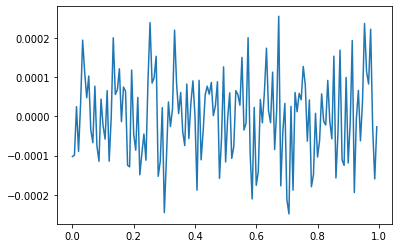

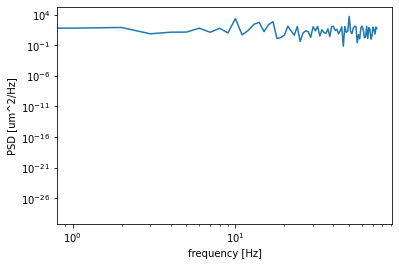

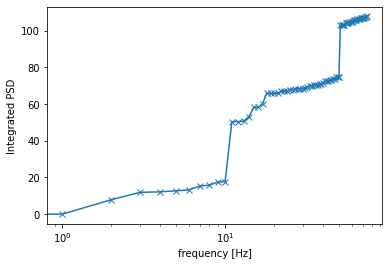

In [6]:
# Time configuration 
f_turn = 1500
fs = 150
t_max = 1

ts = 1/fs
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)
freqs = np.fft.fftfreq(N, 1/fs)

f_ratio = 10
fs_real = f_ratio*fs
Ts_real = 1/fs_real
t_real = np.arange(0, f_ratio*t.size) / fs_real

# Perturbations

# fmin=1e-6
# fmax=1
# perturbation_samples = sinesweep(t, fmin, fmax, amplitude = 0.0001)

# ******
# 
perturbation_samples = real_perturbation(t) * 1e-4

# ******

# fsin = 1
# amplitude = 0.00001
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

# ******

# t0 = 0.1
# perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.00001])

# ******

# import colorednoise as cn

# beta = 2 # the exponent
# samples = N # number of samples to generate
# perturbation_samples = cn.powerlaw_psd_gaussian(beta, samples) * 10e-6

# ******

# perturbation_samples = spectrum_noise(lambda x:pink_spectrum(x, 0, 1000), N, fs) * 10e-6
# perturbation_samples = spectrum_noise(lambda f: 1 / f**4, N, fs) * 10e-6

# ******

plt.plot(t, perturbation_samples)
plt.figure()
plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:N//2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [um^2/Hz]')

plt.figure()

aux = []
for f in range(0, N//2):
    aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:f])))
plt.plot(freqs[:N//2], aux, 'x-')
plt.xlabel('frequency [Hz]')
plt.ylabel('Integrated PSD')
plt.xscale('log')

In [7]:
%matplotlib inline

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 80
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t_real.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t_real.size, len(bpm_ids)))
orbit_off = np.zeros((t_real.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
rms_off = []
x_lp = np.zeros(len(bpm_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(cor_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 3e-3
# loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs_real) 
print(delay_offset)

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

d = np.zeros(t_real.size)

du_s = np.zeros((t.size, len(cor_ids)))
e_s = np.zeros((t.size, len(cor_ids)))

u = np.zeros((t_real.size, len(cor_ids)))
e = np.zeros((t_real.size, len(cor_ids)))

u_delay = np.zeros((t_real.size, len(cor_ids)))

x = 0
xp = 0
y = 0
yp = 0
dp = 0 

x_off = 0
xp_off = 0
y_off = 0
yp_off = 0
dp_off = 0 

# Simulation
sample = 0
for n in tqdm(range(1, t_real.size)):
    d[n] = perturbation_samples[sample]

    # Low pass filter
    filter_out, x_lp = apply_f(num_lp, den_lp, reference_orbit - orbit[n-1, :], x_lp, Ts_real)

    if t_real[n] >= t[sample] and sample < t.size-1:    
        sample += 1
        # Corrector space
        e_s[sample, :] = np.dot(Rcinv.T, filter_out)

        # PID controller
        du_s[sample, :], x_pid = apply_f(num_pid, den_pid, e_s[sample, :], x_pid, ts)

    # Correction sent to correctors
    e[n, :] = e_s[sample, :]
    u[n, :]  = du_s[sample, :]


    # Apply delay
    if n >= delay_offset:
        u_delay[n, :] = u[n - delay_offset, :]
  
    # Response of the ring
    at.shift_elem(lat[quad_ids[0]], deltax=d[n], deltaz=0.0, relative=False)
    # change_magnets_alignment(lat, d[n])
    # print(u_delay[n, :])
    # change_correctors_kick_angle(lat,  u_delay[n, :])
    pout = tracking(x, xp, y, yp, dp, lat, 1, refpts = bpm_ids)
    # pout = tracking(x, xp, y, yp, dp, lat, int(f_turn / fs_real), refpts = bpm_ids)
    orbit[n, :] = pout[0, 0, :, -1]
    x = pout[0, 0, -1, -1]
    xp = pout[1, 0, -1, -1]
    y = pout[2, 0, -1, -1]
    yp = pout[3, 0, -1, -1]
    dp = pout[4, 0, -1, -1]

    # Whithout correction
    # at.shift_elem(lat2[quad_ids[0]], deltax=d[n], deltaz=0.0, relative=False)
    # # change_magnets_alignment(lat2, d[n])
    # pout2 = tracking(x_off, xp_off, y_off, yp_off, dp_off, lat2, 1, refpts = bpm_ids)
    # # pout2 = tracking(x_off, xp_off, y_off, yp_off, dp_off, lat2, int(f_turn / fs_real), refpts = bpm_ids)
    # orbit_off[n, :] = pout2[0, 0, :, -1]
    # x_off = pout2[0, 0, -1, -1]
    # xp_off = pout2[1, 0, -1, -1]
    # y_off = pout2[2, 0, -1, -1]
    # yp_off = pout2[3, 0, -1, -1]
    # dp_off = pout2[4, 0, -1, -1]
    
    # print((orbit[n, :]==orbit_off[n, :]).all())

    # Results
    rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))
    # rms_off.append(np.sqrt(np.mean(np.square(orbit_off[n, :]))))

5


100%|██████████| 1499/1499 [04:03<00:00,  6.15it/s]


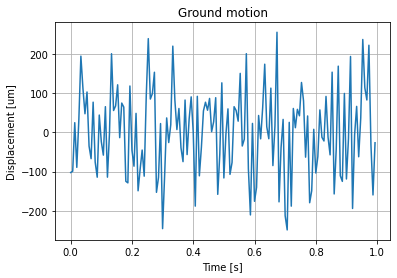

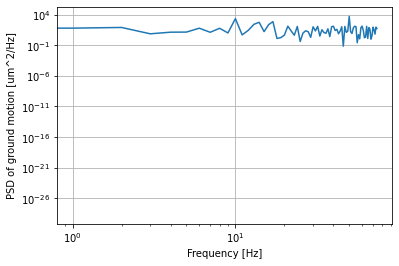

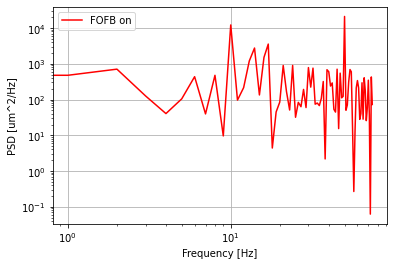

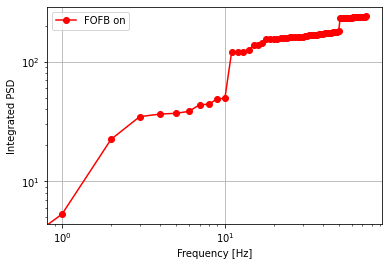

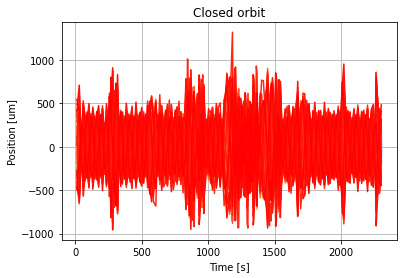

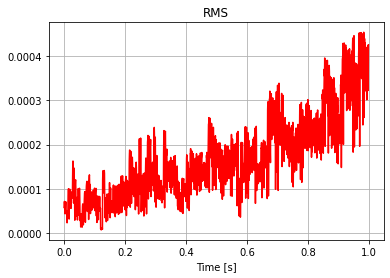

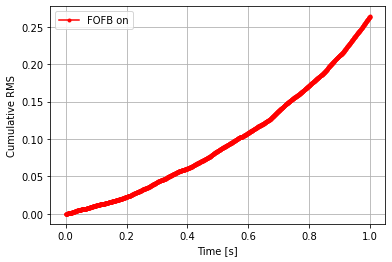

In [8]:
# Plotting
plt.plot(t, perturbation_samples[:] * 1e6)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [um]')
plt.title('Ground motion')
plt.grid()

plt.figure()

plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * perturbation_samples)/N))**2))[:N//2])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD of ground motion [um^2/Hz]')
plt.grid()

plt.figure()

# plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * orbit_off[:, 0])/N))**2))[:N//2], 'b-', label="FOFB off")
plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((1e6 * orbit[:, 0])/N))**2))[:N//2], 'r-', label="FOFB on")
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [um^2/Hz]')
plt.legend()
plt.grid()

plt.figure()

aux = []
aux2 = []
for f in range(0, N//2):
    # aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * orbit_off[:, 0])/N))**2))[:f])))
    aux2.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((1e6 * orbit[:, 0])/N))**2))[:f])))
# plt.loglog(freqs[:N//2], aux, 'bx-', label="FOFB off")
plt.loglog(freqs[:N//2], aux2, 'ro-', label="FOFB on")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Integrated PSD')
plt.xscale('log')
plt.legend()
plt.grid()

plt.figure()

color = iter(plt.cm.rainbow(np.linspace(0, 1, int(t_real.size/10))))
for n in range(1, t_real.size):
    if n%10 == 1:
        c = next(color)
        plt.plot(s_pos, 1e6 * orbit[n, :], c=c, label=n)
# plt.legend(loc='best')
plt.ylabel('Position [um]')
plt.xlabel('Time [s]')
plt.title('Closed orbit')
plt.grid()

plt.figure()

# plt.plot(t_real[:len(t_real)-1], rms_off, 'b-', label="FOFB off")
plt.plot(t_real[:len(t_real)-1], rms, 'r-', label="FOFB on")
plt.xlabel('Time [s]')
plt.title('RMS')
plt.grid()

plt.figure()

au = []
au_off = []
for cont in range(0, t_real.size):
    # au_off.append(np.sum(rms_off[:cont]))
    au.append(np.sum(rms[:cont]))
# plt.plot(t_real, au_off, 'b.-', label="FOFB off")
plt.plot(t_real, au, 'r.-', label="FOFB on")
plt.xlabel('Time [s]')
plt.ylabel('Cumulative RMS')
plt.legend()
plt.grid()

# ****************************************************************

In [ ]:
# ts = 1/150
# wc = 2 * np.pi * 715
# num = [wc]
# den = [1, wc]
Kp = 1
Ki = 1
Kd = 2
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

wc = 2 * np.pi * 30
num_lp = [wc]
den_lp = [1, wc]
    
sys = signal.TransferFunction(num_lp, den_lp)

w , mag, phase = signal.bode(sys)
plt.plot(w, mag)
plt.figure()
plt.plot(w, phase)

In [ ]:
%matplotlib inline

# Time configuration 
fs = 150
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-3
# fmax=75
# perturbation_samples = sinesweep(t, fmin, fmax)

# fsin = 10
# amplitude = 1
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

t0 = 0.1
perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 200
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
quad_offset2 = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(quad_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# Simulation
for n in tqdm(range(1, t.size)):
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]
    quad_offset2[n, :], x_lp = apply_f(num_lp, den_lp, quad_offset[n, :], x_lp, ts)

freqs = np.fft.fftfreq(N, 1/fs)
plt.plot(freqs[:N//2], np.abs(np.fft.fft(perturbation_samples))[:N//2]*(2/len(perturbation_samples)))
plt.xlabel('Frequency [Hz]')
plt.title('Perturbation PSD')

plt.figure()

plt.plot(freqs[:N//2], np.abs(np.fft.fft(quad_offset2[:, 0]))[:N//2]*(2/len(quad_offset2[:, 0])))
plt.xlabel('Frequency [Hz]')
plt.title('Error PSD in element 0')

In [ ]:
def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(f, np.abs(np.fft.rfft(s)))

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N))
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S
        return np.fft.irfft(X_shaped)

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

plt.figure(figsize=(8, 8))
for G in [pink_noise]:
    plot_spectrum(G(2**14))
plt.ylim([1e-3, None])